# Modal Wave Climate
In this notebook, the modal wave conditions, seasonal changes and long term trends in wave climate are determined

## Dependencies

In [91]:
import numpy as np
import pandas as pd
import netCDF4
from netCDF4 import Dataset as NetCDFFile 
from netCDF4 import num2date, date2num, date2index
import datetime as dt
import re
import seaborn as sns
import pymannkendall as mk
import matplotlib.pyplot as plt

## A. Import file created by Notebook1


## Arguments

- lat: latitude
- lon: longitude
- wh: significant wave height
- t: time
- qc: quality control flag, one represents "probably good data" (Ribal and Young 2019)
- back: backscatter
- ws: windspeed
- T: wave period

In [3]:
nameCSV = 'sydney_data.csv'
df = pd.read_csv(str(nameCSV), sep=r'\s+', engine='c', header=0, na_filter=False, \
                               dtype=np.float, low_memory=False)

data = df.sort_values(by=['tt'])

lat = data.values[:,0]
lon = data.values[:,1]
wh = data.values[:,2]
tt = data.values[:,3]
qc = data.values[:,4]
back =data.values[:,5]
ws = data.values[:,6]

In [39]:
len(tt)

13959

## B. Show Satellite Tracks

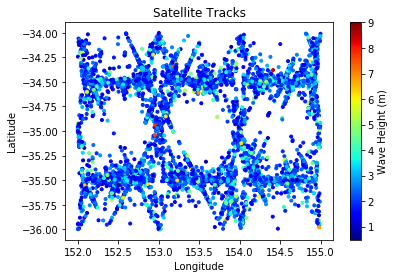

In [93]:
fig, ax = plt.subplots()

marker_size = 10
im = ax.scatter(lon,lat, c=wh, cmap=plt.cm.jet, marker = '.')
fig.colorbar(im, ax=ax, label='Wave Height (m)')

plt.title("Satellite Tracks")
plt.xlabel("Longitude")
plt.ylabel("Latitude")            
plt.show()

## C. Find the number of days of observations

In [9]:
days = [] #daystart
for k in range(len(tt)):
       
    t1 = netCDF4.num2date(tt[k],u'days since 1985-01-01 00:00:00 UTC')
    if k == 0: #get day 0. Then else: every day after that
        days.append(0)
        dd = netCDF4.num2date(tt[k],u'days since 1985-01-01 00:00:00 UTC')
        it = 0
    else:
        if t1.day != dd.day: #if day 1 is not equal to day 2, then append
            #print dd.day,t1.day
            days.append(k)
            it += 1
            dd = netCDF4.num2date(tt[k],u'days since 1985-01-01 00:00:00 UTC')

In [10]:
alltime = num2date(tt[:],u'days since 1985-01-01 00:00:00 UTC')
r = netCDF4.num2date(tt[days],u'days since 1985-01-01 00:00:00 UTC')

### Use days2 for graphing and making dataframes where the date, not index position, is needed

In [58]:
days2 = [] #daystart
for k in range(len(alltime)):
       
    t1 = alltime[k]
    if k == 0: #get day 0. Then else: every day after that
        days2.append(alltime[k])
        dd =alltime[k]
        it = 0
    else:
        if t1.day != dd.day: #if day 1 is not equal to day 2, then append
            #print dd.day,t1.day
            days2.append(alltime[k])
            it += 1
            dd = alltime[k]
print ("Days of satellite coverage:", len(tt[days]))

Days of satellite coverage: 4315


## D. Wave period equation 
From Govindan et al. (2011).

$ \epsilon = 3.25 \left( H_s^2 g^2/U^4 \right)^{0.31}$


In [46]:
def waveage(H, U, grav=9.80665):
    '''
    The pseudo wave age can be expressed in terms of significant wave height and surface wind speed.
    '''

    grav2 = grav**2
    wh2 = np.square(H) 
    u4 = np.power(U,4)
    tmp = np.divide(wh2*grav2,u4)
    eps = 3.25*np.power(tmp,0.31)
    
    return eps


def waveperiod(H, U, grav=9.80665):
    '''
    Wave age from GA-2, Govindan et al.
    '''

    eps = waveage(H, U, grav=9.80665)
    period = (((eps-(5.78))/(eps+(U/(H*((U/H)+H)))))+(H+(5.70)))
    
    return period

In [57]:
T = waveperiod(wh,ws)
print (T)
print (len(T), len(wh))

[6.81526653 7.56809023 8.19486109 ... 4.94714102 5.82886067 5.90032156]
13959 13959


### Parameters for each day

In [60]:
dayswh = wh[days] #wave height for each day
daysTz = T[days]
dayslon = lon[days]
dayslat = lat[days]

print (len(dayswh))
print (len(daysTz))
print (len(dayslon))
print (len(dayslat))

4315
4315
4315
4315


## E. Calculate Wave Power



### Total Wave Energy
# $E = \frac{1}{8} \left(pgH_s^2\right) $


In [120]:
def totalwaveenergy(wh):
    
    '''
    The total wave energy can be calculated using wave height, gravity and water density
    '''
    
    x = 1./8.
    p = 1025. #sea water density, kg/m^3
    g = 9.80665
    h2 = np.square(wh) 
    
    pgh = p*g*h2
    
    e = x*pgh
    
    return e

In [121]:
we = totalwaveenergy(wh)

### Wave energy speed / Wave Velocity

# $Cg = \frac{g}{2\pi} * Tz $


In [63]:
import math
def airywavespeed(T):
    '''
    Airy wave theory wave speed
    '''
    g = 9.80665
    pi = 2*math.pi
    gpi = g/pi
    Cg = gpi *T
    return Cg

In [64]:
speed = airywavespeed(T)
speed

array([10.63711004, 11.81209983, 12.79034925, ...,  7.72138304,
        9.09755064,  9.20908514])

### Wave Energy Flux
# $P = ECg$

In [65]:
def waveenergyflux(H,T):
    '''
    The rate at which energy is carried by waves, determined using total wave energy and wave energy speed, kW/m
    '''
    
    e = totalwaveenergy(H)
    Cg = airywavespeed(T)
    y = 0.001 # convert from W/m to kW/m
    P = e * Cg*y
    
    return P

In [66]:
power1 = waveenergyflux(wh,T)
pp = power1[days]

## F. Make dataframe

In [68]:
df = pd.DataFrame(data={"date": days2, "wh":dayswh, "period":daysTz, "power":pp, "lon":dayslon, "lat":dayslat})
df.to_csv("sydney_timeseries.csv", sep=',',index=False)

### Get rolling average values based on 30 Days


In [69]:
yrolling = df.rolling('30D', on = 'date', min_periods = 1).mean()

In [70]:
wh_rolling=yrolling['wh']
period_rolling=yrolling['period']
power_rolling = yrolling['power']

### Incorporate rolling averages into dataframe

In [71]:
df = pd.DataFrame(data={"date": days2, "wh":dayswh, "wh_rolling":wh_rolling, "period":daysTz, "period_rolling":period_rolling, "power":pp, "power_rolling":power_rolling })
df.to_csv("sydney_timeseries.csv", sep=',',index=False)

## G. Timeseries
### Find date when there is a signficant data gap due to no operating satellites (will be slightly different depending on location)

In [87]:
print (df.date[166])
print (df.date[167])

1988-08-11 22:40:05.562497
1992-10-14 18:56:46.687497


In [95]:
#Define variables, putting the correct index when there is a significant data gap from above

#Period normal    
time1 = df.period[0:166]
time2 = df.period[167:-1]

#Period rolling
tt1 = df.period_rolling[0:166]
tt2 = df.period_rolling[167:-1]
        


#Wh normal
y1 = df.wh[0:166]
y2 = df.wh[167:-1]

#wh rolling
yy1 = df.wh_rolling[0:166]
yy2 = df.wh_rolling[167:-1]


#power normal
p1 = df.power[0:166]
p2=df.power[167:-1]

#power rolling
pp1 = df.power_rolling[0:166]
pp2 = df.power_rolling[167:-1]


#Date, from above
x1=df.date[0:166]
x2 = df.date[167:-1]

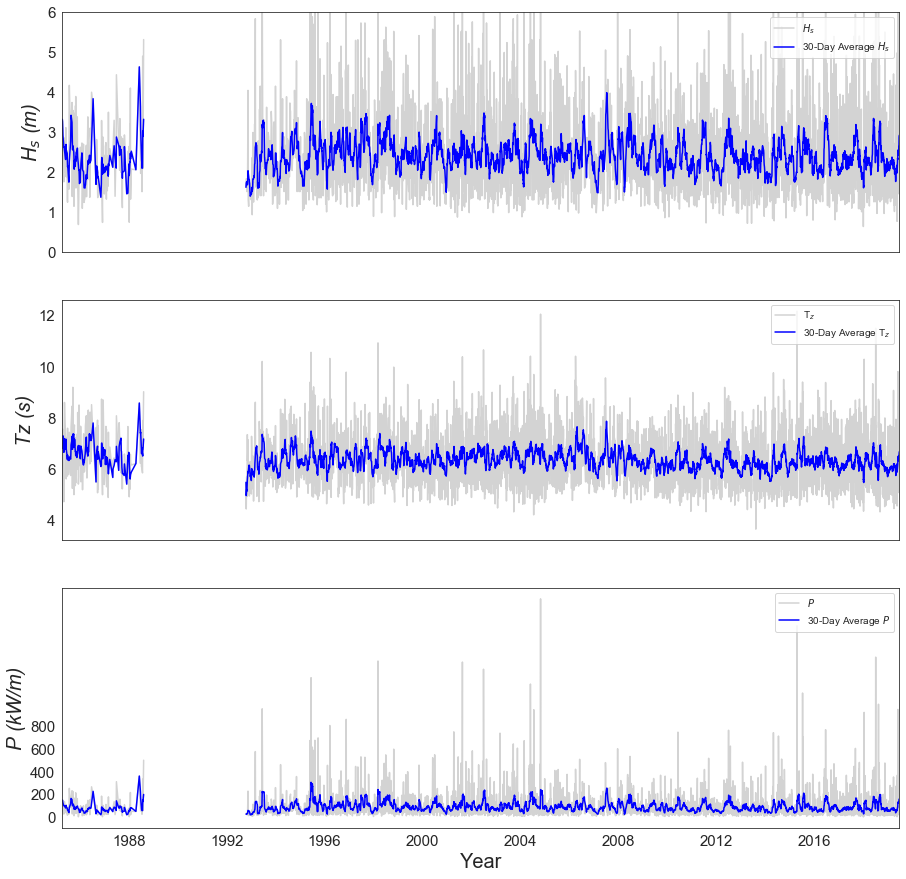

In [96]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex = True,figsize = (15,15))    
sns.set_style("white")

#Wh
#Before date break
ax1.plot(x1,y1,color='lightgrey',label="$H_s$")
ax1.plot(x1,yy1,color='blue',label="30-Day Average $H_s$")

#After date break
ax1.plot(x2,y2,color='lightgrey', label='False')
ax1.plot(x2,yy2,color='blue')

ax1.legend(labels=["$H_s$","30-Day Average $H_s$"], loc='upper right')
ax1.set_ylabel("H$_s$ (m)",style = 'italic',fontsize=20)
ax1.set_ylim(0,6)
ax1.tick_params(axis='y', which='both', labelsize=15)


#Wave Period 
#Before date break
ax2.plot(x1, time1, color='lightgrey')
ax2.plot(x1,tt1,color='blue')

#After date break
ax2.plot(x2,time2, color='lightgrey')
ax2.plot(x2,tt2,color='blue')

ax2.legend(labels=['T$_\mathit{z}$',"30-Day Average T$_\mathit{z}$"], loc='upper right')
ax2.set_ylabel("Tz (s)",style = 'italic',fontsize=20)
ax2.tick_params(axis='y', which='both', labelsize=15)


#Wave Power 
#Before date break
ax3.plot(x1, p1,color='lightgrey')
ax3.plot(x1,pp1,color='blue')

#After date break
ax3.plot(x2,p2,color='lightgrey')
ax3.plot(x2,pp2,color='blue')

ax3.legend(labels=['$\mathit{P}$',"30-Day Average $\mathit{P}$"], loc='upper right')
ax3.set_ylabel("P (kW/m)", style = 'italic',fontsize=20)
ax3.tick_params(axis='y', which='both', labelsize=15)
ax3.set_yticks(ticks =(0,200,400,600,800))



#Formatting
ax3.tick_params(axis='x', which='both', labelsize=15)
ax3.set_xlabel("Year", fontsize=20)
#ax3.xaxis.set_minor_locator(AutoMinorLocator())

ax3.set_xlim(min(x1),max(x2))
years = pd.date_range('2008','2015', freq='AS')

plt.savefig("Timeseries")

## H. Calculate mean, median, 95th percentile and maximum values for each parameter

In [98]:
print ('mean wh', np.mean(df.wh))
print ('median wh', np.median(df.wh))
print ('95th percentile wh', np.percentile(df.wh,95))
print ('max wh', max(df.wh))

print ('mean tz', np.mean(df.period))
print ('median tz', np.median(df.period))
print ('95th percentile tz', np.percentile(df.period,95))
print ('max tz', max(df.period))

print ('mean power', np.mean(df.power))
print ('median power', np.median(df.power))
print ('95th percentile power', np.percentile(df.power,95))
print ('max power', max(df.power))

mean wh 2.404243915989943
median wh 2.1715002059936523
95th percentile wh 4.366000175476073
max wh 9.005000114440918
mean tz 6.36595007109757
median tz 6.229167254832982
95th percentile tz 8.101587162838303
max tz 12.1687594142067
mean power 92.55437978377147
median power 57.53986740883763
95th percentile power 283.32447349540547
max power 1916.0310002545846


## I. Find any values above a certain value
For example, find the wave height, period, power and date of each satellite record when wave height is greater than 6 m.

In [102]:
for k in range(len(days)):
    if df.wh[k]>6:
        print (df.wh[k], df.period[k], df.power[k], df.date[k])

6.896000385284424 10.205904015605407 951.7905640277451 1993-06-13 08:01:06.976566
6.047000408172607 9.394714637847647 673.6882148318563 1995-05-27 12:38:56.281253
7.690000534057617 10.559844025942127 1224.6320031920764 1995-06-12 12:36:05.335942
6.2250003814697275 8.889726663514079 675.5578326141579 1995-08-08 12:44:44.812504
6.5335001945495605 8.322250434359704 696.6713620597152 1995-09-25 12:36:07.203121
6.306500434875487 10.324220530804062 805.2477017114408 1996-03-18 12:36:02.257815
6.690500259399414 9.788562014096243 859.2735458491326 1996-11-18 12:35:59.492189
7.998499870300293 10.928907061496604 1371.163292370366 1998-03-07 12:38:48.335933
6.366000175476074 9.431917865386566 749.5984224699473 2001-04-12 03:41:14.117188
8.177000045776367 10.386874229063388 1361.972173241088 2001-08-18 12:37:54.546876
7.885000228881836 10.656268560845913 1299.2835467034918 2002-06-29 11:15:16.562503
6.369000434875487 9.279993977138409 738.2196695904513 2003-03-02 12:51:05.554686
6.158000469207764 

#  Monthly values
The average wave height for each month, in each year

## I. Monthly dataframe for wave height. Can use for period, power, wind speed and other parameters

In [103]:
# use this to make year/month df for each year
def getMeanH(month,year):
    valwh = []
    for k in range(len(days)):
        if r[k].year == year and r[k].month == month:
            valwh.append(wh[days[k]])

    return np.mean(valwh)

In [104]:
my93 = []
my94 = []
my95 = []
my96 = []
my97 = []
my98 = []
my99 = []
my00 = []
my01 = []
my02 = []
my03 = []
my04 = []
my05 = []
my06 = []
my07 = []
my08 = []
my09 = []
my10 = []
my11 = []
my12 = []
my13 = []
my14 = []
my15 = []
my16 = []
my17 = []
my18 = []


for k in range(1,13):
    my93.append(getMeanH(k,1993))
    my94.append(getMeanH(k,1994))
    my95.append(getMeanH(k,1995))
    my96.append(getMeanH(k,1996))
    my97.append(getMeanH(k,1997))
    my98.append(getMeanH(k,1998))
    my99.append(getMeanH(k,1999))
    my00.append(getMeanH(k,2000))
    my01.append(getMeanH(k,2001))
    my02.append(getMeanH(k,2002))
    my03.append(getMeanH(k,2003))
    my04.append(getMeanH(k,2004))
    my05.append(getMeanH(k,2005))
    my06.append(getMeanH(k,2006))
    my07.append(getMeanH(k,2007))
    my08.append(getMeanH(k,2008))
    my09.append(getMeanH(k,2009))
    my10.append(getMeanH(k,2010))
    my11.append(getMeanH(k,2011))
    my12.append(getMeanH(k,2012))
    my13.append(getMeanH(k,2013))
    my14.append(getMeanH(k,2014))
    my15.append(getMeanH(k,2015))
    my16.append(getMeanH(k,2016))
    my17.append(getMeanH(k,2017))
    my18.append(getMeanH(k,2018))   

In [105]:
index= ('January', 'February','March','April','May','June','July','August','September','October','November','December')
df_wh = pd.DataFrame(data={
'1993':my93,
"1994":my94,
'1993':my93,
'1994':my94,
'1995':my95,
'1996':my96,
'1997':my97,
'1998':my98,
'1999':my99,
'2000':my00,
'2001':my01,
'2002':my02,
'2003':my03,
'2004':my04,
'2005':my05,
'2006':my06,
'2007':my07,
'2008':my08,
'2009':my09,
'2010':my10,
'2011':my11,
'2012':my12,
'2013':my13,
'2014':my14,
'2015':my15,
'2016':my16,
'2017':my17,
'2018':my18}, index=index)

In [106]:
wh_transpose =df_wh.transpose()
wh_transpose

,January,February,March,April,May,June,July,August,September,October,November,December
1993,1.842357,2.204000,2.432333,1.650250,2.346857,3.504333,2.087900,2.316714,2.520167,2.488600,1.887417,2.608000
1994,1.588667,1.887500,2.562400,2.502667,2.317917,2.256583,2.188929,2.906833,2.529083,3.056250,2.776143,1.913750
1995,1.949000,1.667833,2.247917,2.256333,2.904111,3.387750,2.991800,2.391000,2.499750,2.910572,2.201250,2.724700
1996,1.788125,2.347000,2.745700,2.106889,2.659546,2.720857,2.733625,2.373455,3.073778,2.227556,3.139100,2.616150
1997,2.374450,2.018714,2.906333,2.074550,2.706450,3.416100,2.614273,3.235278,2.882556,2.688875,1.904600,2.014136
1998,2.460625,2.391072,3.161046,2.436364,2.963500,2.648111,3.389300,2.811563,2.621200,2.818688,1.945056,2.333773
1999,1.832714,2.576813,2.440400,2.772417,2.250722,2.230818,2.445000,2.253333,2.486700,2.196938,2.424409,2.182583
2000,2.393429,2.308700,2.671250,1.805583,2.466591,3.071000,2.629714,2.646500,2.730267,2.310429,2.039393,2.071773
2001,2.322500,2.054572,2.661208,2.293633,2.589308,2.232808,2.687500,2.948611,1.911800,2.592250,2.584462,2.172150
2002,2.807559,2.479046,2.220385,2.463472,2.552769,3.366734,2.307933,2.655115,1.988395,2.363357,2.227342,2.197567


In [107]:
wh_stack = wh_transpose.stack()
wh_stack.to_csv("wh_years.csv", sep=',',index=1)

C:\Users\SMI9DD\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


## Average monthly wave height plot

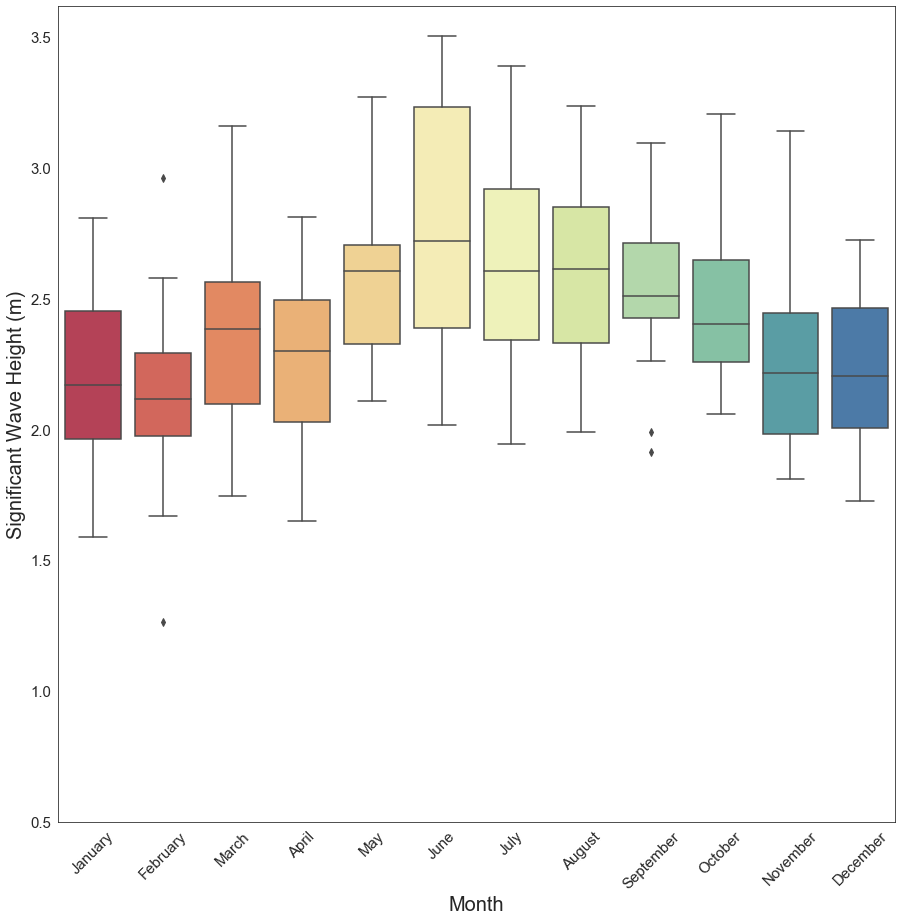

In [108]:
fig, ax = plt.subplots(figsize = (15,15))
sns.boxplot(data = wh_transpose[:], palette='Spectral')
ax.set_ylabel("Significant Wave Height (m)",fontsize = 20)
ax.set_xlabel('Month',fontsize = 20)


ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15, rotation=45)

ax.set_yticks(ticks=(0.5,1.0,1.5,2.0,2.5,3.0,3.5))

### Interannual variability Standard Deviation

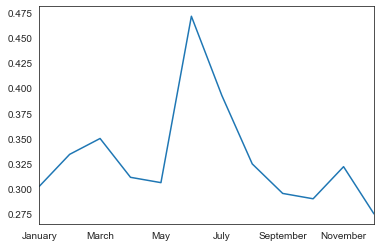

In [117]:
monthly_sd = wh_transpose.std(axis=0) 
monthly_sd.plot()

## K. Seasonal Kendall Test
Determines the trend accounting for seasonality in data. Package from Hussain & Mahmud (2019). Slope indicates change in the parameter unit per year. For Sydney, there is a decrease of 0.5cm/year significant wave height from altimeter records.

In [119]:
monthly = mk.seasonal_test(wh_stack, period=12)
monthly

Seasonal_Mann_Kendall_Test(trend='decreasing', h=True, p=0.038647031050964786, z=-2.0679254796712776, Tau=-0.0835897435897436, s=-326.0, var_s=24699.999999999996, slope=-0.0052856091745244575)

## References

Govindan, R., Kumar, R., Basu, S. & Sarkar, A. (2011), ‘Altimeter-derived ocean wave period using genetic algorithm’, IEEE Geoscience and Remote Sensing Letters 8(2)

Hussain, M. M. & Mahmud, I. (2019), ‘pyMannKendall: a python package for
non parametric Mann Kendall family of trend tests’, Journal of Open Source
Software 4(39), 1556.